In [1]:
# importing libraries
import numpy as np
import pandas as pd # to load the datasets
# to preprocess the data
import re
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.corpus import stopwords
# to analyze the data
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
import nltk
import seaborn as sns
# to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# to build the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from id3 import Id3Estimator

In [2]:
# import the datasets
train_data = pd.read_csv('train_E6oV3lV.csv')
test_data = pd.read_csv('test_tweets_anuFYb8.csv')

In [3]:
class preprocess:
    '''
        Class to pre-process the data.
        
        Functions:
        
        remove_user_handle - to remove the user handle or other patterns from the tweet text.
        
        remove_unnecessary_chars - to remove numbers, punctuations and any special characters from the data.
        
        rm_stopwords_stem - to remove the stop words and performing stemming to remove the suffix from the words.
    ''' 
    def __init__(self):
        self.operators = {'and','or','not'}
        self.stop_words = set(stopwords.words('english'))-self.operators

    def remove_user_handle(self, raw_data, pattern):
        r = re.findall(pattern, raw_data)
        for i  in r:
            raw_data = re.sub(i,'', raw_data)
        return raw_data
    
    def remove_unnecessary_chars(self, data):
        data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
        return data
    
    def rm_stopwords_stem(self, data):
        split_sent = data['clean_tweet'].apply(lambda x: x.split())
        filtered_sentence = split_sent.apply(lambda tweet: [ps.stem(word) for word in tweet if not word in self.stop_words]) 
        for i in range(len(filtered_sentence)):
            filtered_sentence[i] =' '.join(filtered_sentence[i])
        data['clean_tweet'] = filtered_sentence
        return data

In [4]:
class analyzing_data:
    '''
        Class to analyze the data.
        
        Functions:
        
        understand_word_sentim - to remove the user handle or other patterns from the tweet text.
        
        check_hashtags - to remove numbers, punctuations and any special characters from the data.
        
        distribution_top_N_words - to remove the stop words and performing stemming to remove the suffix from the words.
    ''' 
    def understand_word_sentim(self, data, label):
        list_of_words = ' '.join([text for text in data['clean_tweet'][data['label'] == label]])
        wordcloud = WordCloud(height = 700, width = 1000, random_state  = 21, max_font_size = 30).generate(list_of_words)
        plt.figure(figsize=(10,7))
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.show()
        
    def check_hashtags(self, data, label):
        hashtags = []
        data = data['clean_tweet'][data['label']==label]
        for row in data:
            ht = re.findall(r'#(\w+)', row)
            hashtags.extend(ht)
        return hashtags
    
    def distribution_top_N_words(self, hashtags, N):
        freq = nltk.FreqDist(hashtags)
        df = pd.DataFrame({'Hashtags': list(freq.keys()),
                     'count': list(freq.values())})
        df = df.nlargest(N, 'count', keep='first')
        plt.figure(figsize=(16, 5))
        ax = sns.barplot(data = df, y='count', x = 'Hashtags')
        plt.xlabel('Top 10 words')
        plt.ylabel('count')
        plt.show()

In [13]:
class feature_extraction:
    '''
        Class to apply feature extraction.
        
        Functions:
        
        extract_using_BOW - converting text into features using Bag of words.
        
        extract_using_tfidf - converting text into features using TF-IDF.
    ''' 
    def extract_using_BOW(self, data):
        cv = CountVectorizer(max_features = 1500, stop_words='english')
        X = cv.fit_transform(data['clean_tweet'])
        return X
    
    def extract_using_tfidf(self, data):
        tf = TfidfVectorizer(max_features = 1500, stop_words='english')
        X = tf.fit_transform(data['clean_tweet'])
        return X

In [6]:
def split_data(dataset):
    '''
        Function to split the dataset into training and validation data
    '''
    # Separate data into training and validation
    X_train, X_test, Y_train, Y_test = train_test_split(dataset, train_data['label'], test_size = 0.20, random_state = 42)
    return X_train, X_test, Y_train, Y_test

In [7]:
class Classification_Models:
    # fitting logistic regression to the training set.
    def LRModel(self, X_train, Y_train):
        classifier_LR = LogisticRegression(solver='liblinear')
        classifier_LR.fit(X_train, Y_train)
        return classifier_LR
    
    def SVMModel(self, X_train, Y_train):
        classifier_SVM = SVC(kernel = 'linear', C = 1, gamma = 'auto', probability = True)
        classifier_SVM.fit(X_train, Y_train)
        return classifier_SVM
    
    def DTModel(self, X_train, Y_train):
        classifier_DT = DecisionTreeClassifier(criterion = 'entropy') #try gini
        classifier_DT.fit(X_train, Y_train)
        return classifier_DT
    
    def RFModel(self, X_train, Y_train):
        classifier_RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
        classifier_RF.fit(X_train, Y_train)
        return classifier_RF
    
    def NBModel(self, X_train, Y_train):
        classifier_NB = MultinomialNB()
        classifier_NB.fit(X_train, Y_train)
        return classifier_NB

In [8]:
def calculate_f1score(Y_test, Y_pred, classifier):
    '''
        Function to calculate the F1-score on the validation dataset.
    '''
    score = f1_score(Y_test, Y_pred)
    print('F1 score of classifier ', classifier, ' is: ', score)
    print('\n')
    return score

In [9]:
def calc_predictions(classifier, X_test):
    '''
        Function to predict the outcome based on the trained model.
    '''
    y_pred = classifier.predict_proba(X_test)
    y_pred_int = y_pred[:,1] >= 0.3
    y_pred_int = y_pred_int.astype(np.int)
    return y_pred_int

In [10]:
def model_comparison(X_train, Y_train, X_test, Y_test):
    '''
        Function for model comparison.
        This function returns the model with the greatest F1-score.
    '''
    max_f1score = 0
    best_classifier = 'Nan'
    cm = Classification_Models()
    LR = cm.LRModel(X_train, Y_train)
    SVM = cm.SVMModel(X_train, Y_train)
    DT = cm.DTModel(X_train, Y_train)
    RF = cm.RFModel(X_train, Y_train)
    NB = cm.NBModel(X_train, Y_train)

    for classifier in ['NB', 'SVM', 'LR', 'RF', 'DT']:
        classifier_val = eval(classifier)
        Y_pred = calc_predictions(classifier_val, X_test)
        score = calculate_f1score(Y_test, Y_pred, classifier)
        if max_f1score < score:
            max_f1score = score
            best_classifier = classifier_val
    return best_classifier, max_f1score

Positive/Neutral sentiments


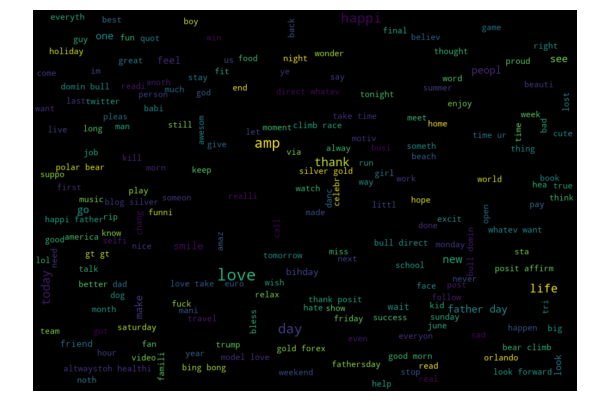

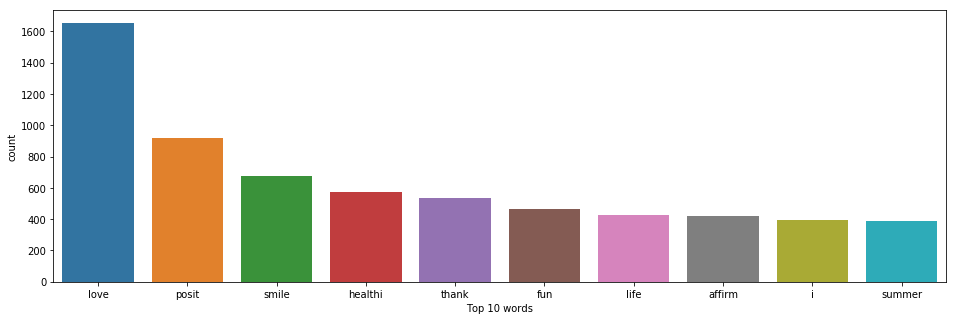

Negative sentiments


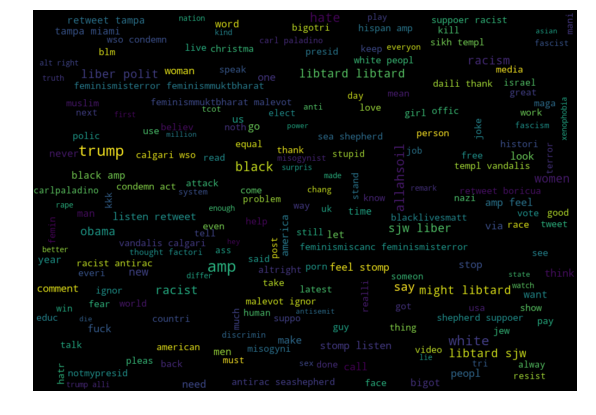

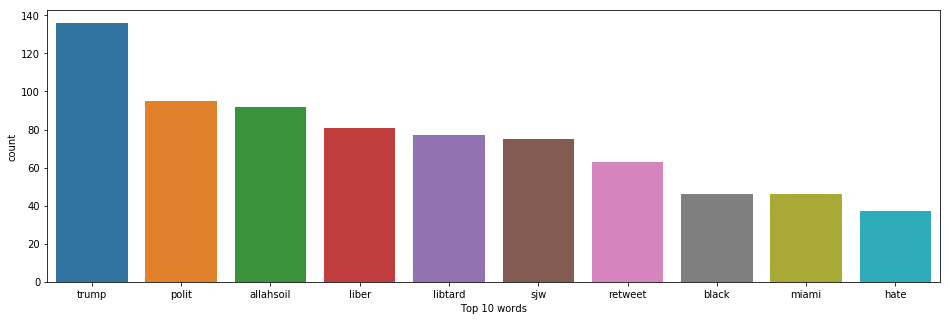

Using BAG OF WORDS: 
F1 score of classifier  NB  is:  0.5512820512820513


F1 score of classifier  SVM  is:  0.5923076923076922


F1 score of classifier  LR  is:  0.5940828402366864


F1 score of classifier  RF  is:  0.5427830596369924


F1 score of classifier  DT  is:  0.5262172284644194


Using TF-IDF: 
F1 score of classifier  NB  is:  0.5797468354430381


F1 score of classifier  SVM  is:  0.5949367088607594


F1 score of classifier  LR  is:  0.605296343001261


F1 score of classifier  RF  is:  0.607920792079208


F1 score of classifier  DT  is:  0.5813953488372092


Using TF-IDF for the final predictions.


In [14]:
# Pre-process the training and test data
p = preprocess()
train_data['clean_tweet'] = np.vectorize(p.remove_user_handle)(train_data['tweet'], "@[\w]*")
p.remove_unnecessary_chars(train_data)
p.rm_stopwords_stem(train_data)

test_data['clean_tweet'] = np.vectorize(p.remove_user_handle)(test_data['tweet'], "@[\w]*")
p.remove_unnecessary_chars(test_data)
p.rm_stopwords_stem(test_data)

# Analyzing training data
a = analyzing_data()
# positive sentiments
try:
    print('Positive/Neutral sentiments')
    a.understand_word_sentim(train_data, 0) 
    pos_hashtags = a.check_hashtags(train_data, 0)
    a.distribution_top_N_words(pos_hashtags, 10)
except:
    print(sys.exc_info()[0],": ", sys.exc_info()[1])
# negative sentiments
try:
    print('Negative sentiments')
    a.understand_word_sentim(train_data, 1) 
    neg_hashtags = a.check_hashtags(train_data, 1)
    a.distribution_top_N_words(neg_hashtags, 10)
except:
    print(sys.exc_info()[0],": ", sys.exc_info()[1])

# Using Bag of Words
# Bag of Words (Count Vectorizer)
fe = feature_extraction()
X_BOW = fe.extract_using_BOW(train_data)

# Tfidf Vectorizer
X_TF = fe.extract_using_tfidf(train_data)

print('Using BAG OF WORDS: ')
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = split_data(X_BOW)
best_classifier_bw, f1_score_bw = model_comparison(X_train_bow, Y_train_bow, X_test_bow, Y_test_bow)

# Using TFidf
print('Using TF-IDF: ')
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = split_data(X_TF)
best_classifier_tf, f1_score_tf = model_comparison(X_train_tf, Y_train_tf, X_test_tf, Y_test_tf)

if f1_score_tf > f1_score_bw:
    print('Using TF-IDF for the final predictions.')
    x_test = fe.extract_using_tfidf(test_data)
    best_classifier = best_classifier_tf
else:
    print('Using BAG OF WORDS for the final predictions.')
    x_test = fe.extract_using_BOW(test_data)
    best_classifier = best_classifier_bw

In [15]:
# Predict output
test_data['label'] = calc_predictions(best_classifier, x_test)
test_data[['id', 'label']].to_csv('test_predictions.csv', index=False)